In [ ]:
from google.colab import drive
drive.mount('/content/drive')

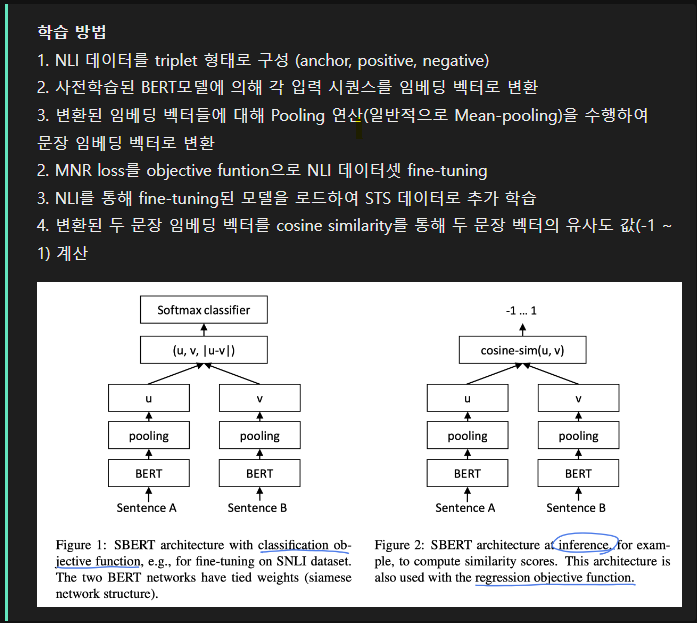

In [ ]:
# 본인의 실습 디렉토리로 변경
% cd /content/drive/MyDrive/Dev/my_workspace/NLP/sentence-transformers/bi-encoder-training

In [ ]:
! pip install sentence_transformers datasets

In [ ]:
import random
import math
import numpy as np
import logging
from datetime import datetime

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, models, LoggingHandler, losses, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample
from sentence_transformers.datasets import NoDuplicatesDataLoader

In [ ]:
# logger
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
    handlers=[LoggingHandler()],
)

In [ ]:
pretrained_model_name = 'klue/roberta-base'
nli_num_epochs = 1
sts_num_epochs = 4
train_batch_size = 32

nli_model_save_path = 'output/training_nli_by_MNRloss_'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
sts_model_save_path = 'output/training_sts_continue_training-'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# 1. Load Dataset & Preprocessing

## 1.1. KLUE-NLI

In [ ]:
# load KLUE-NLI Dataset
klue_nli_train = load_dataset("klue", "nli", split='train')

print('Length of Train : ',len(klue_nli_train))

2022-04-04 05:37:07 - Reusing dataset klue (/root/.cache/huggingface/datasets/klue/nli/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)
Length of Train :  24998


In [ ]:
klue_nli_train[0]

{'guid': 'klue-nli-v1_train_00000',
 'hypothesis': '힛걸 진심 최고로 멋지다.',
 'label': 0,
 'premise': '힛걸 진심 최고다 그 어떤 히어로보다 멋지다',
 'source': 'NSMC'}

In [ ]:
def make_nli_triplet_input_example(dataset):
    '''
    Transform to Triplet format and InputExample
    '''
    # transform to Triplet format
    train_data = {}
    def add_to_samples(sent1, sent2, label):
        if sent1 not in train_data:
            train_data[sent1] = {'contradiction': set(), 'entailment': set(), 'neutral': set()}
        train_data[sent1][label].add(sent2)

    for i, data in enumerate(dataset):
        sent1 = data['hypothesis'].strip()
        sent2 = data['premise'].strip()
        if data['label'] == 0:
            label = 'entailment'
        elif data['label'] == 1:
            label = 'neutral'
        else:
            label = 'contradiction'

        add_to_samples(sent1, sent2, label)
        add_to_samples(sent2, sent1, label) #Also add the opposite

    # transform to InputExmaples
    input_examples = []
    for sent1, others in train_data.items():
        if len(others['entailment']) > 0 and len(others['contradiction']) > 0:
            input_examples.append(InputExample(texts=[sent1, random.choice(list(others['entailment'])), random.choice(list(others['contradiction']))]))
            input_examples.append(InputExample(texts=[random.choice(list(others['entailment'])), sent1, random.choice(list(others['contradiction']))]))

    return input_examples

In [ ]:
nli_train_examples = make_nli_triplet_input_example(klue_nli_train)
nli_train_examples[0].texts

['힛걸 진심 최고다 그 어떤 히어로보다 멋지다', '힛걸 진심 최고로 멋지다.', '힛걸 그 어떤 히어로보다 별로다.']

In [ ]:
# Train Dataloader
nli_train_dataloader = NoDuplicatesDataLoader( # avoid duplicates within a batch
    nli_train_examples,
    batch_size=train_batch_size,
)

## 1.2. KLUE-STS

In [ ]:
# load KLUE-STS Dataset
klue_sts_train = load_dataset("klue", "sts", split='train[:90%]')
klue_sts_valid = load_dataset("klue", "sts", split='train[-10%:]') # train의 10%를 validation set으로 사용
klue_sts_test = load_dataset("klue", "sts", split='validation')

print('Length of Train : ',len(klue_sts_train))
print('Length of Valid : ',len(klue_sts_valid))
print('Length of Test : ',len(klue_sts_test))

2022-04-04 05:37:12 - Reusing dataset klue (/root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)
2022-04-04 05:37:13 - Reusing dataset klue (/root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)
2022-04-04 05:37:13 - Reusing dataset klue (/root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)
Length of Train :  10501
Length of Valid :  1167
Length of Test :  519


In [ ]:
klue_sts_train[0]

{'guid': 'klue-sts-v1_train_00000',
 'labels': {'binary-label': 1, 'label': 3.7, 'real-label': 3.714285714285714},
 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.',
 'source': 'airbnb-rtt'}

In [ ]:
def make_sts_input_example(dataset):
    '''
    Transform to InputExample
    '''
    input_examples = []
    for i, data in enumerate(dataset):
        sentence1 = data['sentence1']
        sentence2 = data['sentence2']
        score = (data['labels']['label']) / 5.0  # normalize 0 to 5
        input_examples.append(InputExample(texts=[sentence1, sentence2], label=score))

    return input_examples

In [ ]:
sts_train_examples = make_sts_input_example(klue_sts_train)
sts_valid_examples = make_sts_input_example(klue_sts_valid)
sts_test_examples = make_sts_input_example(klue_sts_test)

In [ ]:
# Train Dataloader
sts_train_dataloader = DataLoader(
    sts_train_examples,
    shuffle=True,
    batch_size=train_batch_size,
)

# Evaluator by sts-validation
dev_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    sts_valid_examples,
    name="sts-dev",
)

# Evaluator by sts-test
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    sts_test_examples,
    name="sts-test",
)

# 2. Load Embedding Model

In [ ]:
# Load Embedding Model
embedding_model = models.Transformer(
    model_name_or_path=pretrained_model_name,
    max_seq_length=512,
    do_lower_case=True
)

# Only use Mean Pooling -> Pooling all token embedding vectors of sentence.
pooling_model = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

model = SentenceTransformer(modules=[embedding_model, pooling_model])

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

2022-04-04 05:37:41 - Use pytorch device: cuda


# 3. Training by NLI
- Trainset: nli-train
- Devset: sts-dev

## 3.1. training

In [ ]:
# Use MultipleNegativesRankingLoss
train_loss = losses.MultipleNegativesRankingLoss(model)

# warmup steps
warmup_steps = math.ceil(len(nli_train_examples) * nli_num_epochs / train_batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Training
model.fit(
    train_objectives=[(nli_train_dataloader, train_loss)],
    evaluator=dev_evaluator,
    epochs=nli_num_epochs,
    evaluation_steps=int(len(nli_train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=nli_model_save_path,
    use_amp=False       #Set to True, if your GPU supports FP16 operations
)

2022-04-04 05:37:41 - Warmup-steps: 51


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/502 [00:00<?, ?it/s]

2022-04-04 05:38:51 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 0 after 50 steps:
2022-04-04 05:39:00 - Cosine-Similarity :	Pearson: 0.9094	Spearman: 0.9069
2022-04-04 05:39:00 - Manhattan-Distance:	Pearson: 0.9199	Spearman: 0.9048
2022-04-04 05:39:00 - Euclidean-Distance:	Pearson: 0.9202	Spearman: 0.9044
2022-04-04 05:39:00 - Dot-Product-Similarity:	Pearson: 0.8893	Spearman: 0.8807
2022-04-04 05:39:00 - Save model to output/training_nli_by_MNRloss_klue-roberta-base-2022-04-04_05-37-06
2022-04-04 05:40:09 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 0 after 100 steps:
2022-04-04 05:40:18 - Cosine-Similarity :	Pearson: 0.9274	Spearman: 0.9097
2022-04-04 05:40:18 - Manhattan-Distance:	Pearson: 0.9232	Spearman: 0.9029
2022-04-04 05:40:18 - Euclidean-Distance:	Pearson: 0.9235	Spearman: 0.9030
2022-04-04 05:40:18 - Dot-Product-Similarity:	Pearson: 0.8987	Spearman: 0.8851
2022-04-04 05:40:18 - Save model to output/train

# 4. Training by STS (Continue Learning)

## 4.1. Load model of fine-tuning by NLI

In [ ]:
# Load model of fine-tuning by NLI
model = SentenceTransformer(nli_model_save_path)

2022-04-04 05:50:32 - Load pretrained SentenceTransformer: output/training_nli_by_MNRloss_klue-roberta-base-2022-04-04_05-37-06
2022-04-04 05:50:34 - Use pytorch device: cuda


## 4.2. Training

In [ ]:
# Use CosineSimilarityLoss
train_loss = losses.CosineSimilarityLoss(model=model)

# warmup steps
warmup_steps = math.ceil(len(sts_train_examples) * sts_num_epochs / train_batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Training
model.fit(
    train_objectives=[(sts_train_dataloader, train_loss)],
    evaluator=dev_evaluator,
    epochs=sts_num_epochs,
    evaluation_steps=int(len(sts_train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=sts_model_save_path
)

2022-04-04 05:50:34 - Warmup-steps: 132


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/329 [00:00<?, ?it/s]

2022-04-04 05:51:06 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 0 after 32 steps:
2022-04-04 05:51:16 - Cosine-Similarity :	Pearson: 0.9364	Spearman: 0.9094
2022-04-04 05:51:16 - Manhattan-Distance:	Pearson: 0.9254	Spearman: 0.9015
2022-04-04 05:51:16 - Euclidean-Distance:	Pearson: 0.9258	Spearman: 0.9017
2022-04-04 05:51:16 - Dot-Product-Similarity:	Pearson: 0.9196	Spearman: 0.8955
2022-04-04 05:51:16 - Save model to output/training_sts_continue_training-klue-roberta-base-2022-04-04_05-37-06
2022-04-04 05:51:49 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 0 after 64 steps:
2022-04-04 05:51:58 - Cosine-Similarity :	Pearson: 0.9388	Spearman: 0.9007
2022-04-04 05:51:58 - Manhattan-Distance:	Pearson: 0.9224	Spearman: 0.8939
2022-04-04 05:51:58 - Euclidean-Distance:	Pearson: 0.9225	Spearman: 0.8940
2022-04-04 05:51:58 - Dot-Product-Similarity:	Pearson: 0.9312	Spearman: 0.8945
2022-04-04 05:52:32 - EmbeddingSimilarityE

Iteration:   0%|          | 0/329 [00:00<?, ?it/s]

2022-04-04 05:58:32 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 1 after 32 steps:
2022-04-04 05:58:41 - Cosine-Similarity :	Pearson: 0.9589	Spearman: 0.9156
2022-04-04 05:58:41 - Manhattan-Distance:	Pearson: 0.9481	Spearman: 0.9108
2022-04-04 05:58:41 - Euclidean-Distance:	Pearson: 0.9483	Spearman: 0.9109
2022-04-04 05:58:41 - Dot-Product-Similarity:	Pearson: 0.9531	Spearman: 0.9068
2022-04-04 05:58:41 - Save model to output/training_sts_continue_training-klue-roberta-base-2022-04-04_05-37-06
2022-04-04 05:59:17 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 1 after 64 steps:
2022-04-04 05:59:27 - Cosine-Similarity :	Pearson: 0.9571	Spearman: 0.9123
2022-04-04 05:59:27 - Manhattan-Distance:	Pearson: 0.9469	Spearman: 0.9078
2022-04-04 05:59:27 - Euclidean-Distance:	Pearson: 0.9469	Spearman: 0.9078
2022-04-04 05:59:27 - Dot-Product-Similarity:	Pearson: 0.9527	Spearman: 0.9036
2022-04-04 06:00:00 - EmbeddingSimilarityE

Iteration:   0%|          | 0/329 [00:00<?, ?it/s]

2022-04-04 06:05:54 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 2 after 32 steps:
2022-04-04 06:06:03 - Cosine-Similarity :	Pearson: 0.9611	Spearman: 0.9177
2022-04-04 06:06:03 - Manhattan-Distance:	Pearson: 0.9511	Spearman: 0.9133
2022-04-04 06:06:03 - Euclidean-Distance:	Pearson: 0.9512	Spearman: 0.9138
2022-04-04 06:06:03 - Dot-Product-Similarity:	Pearson: 0.9554	Spearman: 0.9089
2022-04-04 06:06:37 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 2 after 64 steps:
2022-04-04 06:06:46 - Cosine-Similarity :	Pearson: 0.9617	Spearman: 0.9192
2022-04-04 06:06:46 - Manhattan-Distance:	Pearson: 0.9523	Spearman: 0.9145
2022-04-04 06:06:46 - Euclidean-Distance:	Pearson: 0.9524	Spearman: 0.9148
2022-04-04 06:06:46 - Dot-Product-Similarity:	Pearson: 0.9556	Spearman: 0.9098
2022-04-04 06:07:18 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 2 after 96 steps:
2022-04-04 06:07:27 - Cosine-Simila

Iteration:   0%|          | 0/329 [00:00<?, ?it/s]

2022-04-04 06:13:14 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 3 after 32 steps:
2022-04-04 06:13:23 - Cosine-Similarity :	Pearson: 0.9616	Spearman: 0.9197
2022-04-04 06:13:23 - Manhattan-Distance:	Pearson: 0.9499	Spearman: 0.9136
2022-04-04 06:13:23 - Euclidean-Distance:	Pearson: 0.9501	Spearman: 0.9139
2022-04-04 06:13:23 - Dot-Product-Similarity:	Pearson: 0.9541	Spearman: 0.9082
2022-04-04 06:13:55 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 3 after 64 steps:
2022-04-04 06:14:05 - Cosine-Similarity :	Pearson: 0.9623	Spearman: 0.9209
2022-04-04 06:14:05 - Manhattan-Distance:	Pearson: 0.9517	Spearman: 0.9154
2022-04-04 06:14:05 - Euclidean-Distance:	Pearson: 0.9519	Spearman: 0.9157
2022-04-04 06:14:05 - Dot-Product-Similarity:	Pearson: 0.9549	Spearman: 0.9091
2022-04-04 06:14:05 - Save model to output/training_sts_continue_training-klue-roberta-base-2022-04-04_05-37-06
2022-04-04 06:14:39 - EmbeddingSimilarityE

# 5. Evaluation

In [ ]:
# evaluation sts-test
test_evaluator(model, output_path=sts_model_save_path)

2022-04-04 06:20:14 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-04-04 06:20:18 - Cosine-Similarity :	Pearson: 0.8901	Spearman: 0.8893
2022-04-04 06:20:18 - Manhattan-Distance:	Pearson: 0.8867	Spearman: 0.8818
2022-04-04 06:20:18 - Euclidean-Distance:	Pearson: 0.8875	Spearman: 0.8827
2022-04-04 06:20:18 - Dot-Product-Similarity:	Pearson: 0.8786	Spearman: 0.8735


0.8892573547643868